### Processing demographic data

Demographic data gives the number of females and males for each country for each age group. This code combines the total number of males and females for each country and divides it by the total population. Then save it as pop_by_age_frac

Note: the values are given in the order of millions so must multiply by 1e6

In [2]:
import geopandas as gpd
import xarray as xr
from cartopy import crs as ccrs
import seaborn as sns; sns.set_theme()
import os
import fiona
import country_converter as coco
import dask
import dask.array as da
import netCDF4 as nc
import regionmask
from matplotlib import cm
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from glob import glob

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [212]:
# Gridded Population of the World, Version 4 (GPWv4): National Identifier Grid, Revision 11
# can be downloaded from: https://www.earthdata.nasa.gov/data/catalog/sedac-ciesin-sedac-gpwv4-natiden-r11-4.11#:~:text=Description,use%20in%20aggregating%20population%20data.
# cited as: Center For International Earth Science Information Network-CIESIN-Columbia University. (2018). Gridded Population of the World, Version 4 (GPWv4): National Identifier Grid, Revision 11 (Version 4.11) [Data set]. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H4TD9VDP
shapefile_path = "./gpw-v4-national-identifier-grid-rev11_15_min_asc/gpw_v4_national_identifier_grid_rev11_15_min.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)


In [32]:
# The age range are as follows
# >25 - 0.1430
# Age ranges and their corresponding theta values
age_theta = {
    '25to29': 0.1585,
    '30to34': 0.1577,
    '35to39': 0.1570,
    '40to44': 0.1558,
    '45to49': 0.1532,
    '50to54': 0.1499,
    '55to59': 0.1462,
    '60to64': 0.1421,
    '65to69': 0.1374,
    '70to74': 0.1319,
    '75to79': 0.1253,
    '80to84': 0.1141
}

In [214]:
population = xr.Dataset()
#population.coords['age'] = (('age'), list(age_theta))
population.coords['region']  = (('region'),xx.Region.values)


In [189]:
for i in range(12):
    xx = pd.read_excel(f'./demographic/countries/female/{list(age_theta)[i]}.xlsx', header=0)[:-2]
    xy = pd.read_excel(f'./demographic/countries/male/{list(age_theta)[i]}.xlsx', header=0)[:-2]
    total = xx[2020]+xy[2020]
    population[list(age_theta)[i]] = (("region"),total*1e6)

In [191]:
#SSD (South Sudan) will take data from SDN (Sudan)
ssd_data = population.sel(region = 'SDN').copy(deep=True)
ssd_data = ssd_data.assign_coords(region="SSD")
population = xr.concat([population, ssd_data], dim="region")

In [192]:
#ESH will take data from MAR
esh_data = population.sel(region = 'MAR').copy(deep=True)
esh_data = esh_data.assign_coords(region="ESH")
population = xr.concat([population, esh_data], dim="region")

In [193]:
#KOS Kosovo will take data from Serbia (SRB)
kos_data = population.sel(region = 'SRB').copy(deep=True)
kos_data = kos_data.assign_coords(region="KOS")
population = xr.concat([population, kos_data], dim="region")

In [194]:
#TWN Taiwan will take data from China
twn_data = population.sel(region = 'CHN').copy(deep=True)
twn_data = twn_data.assign_coords(region="TWN")
population = xr.concat([population, twn_data], dim="region")

In [195]:
population = population.sortby("region")

### check which countries it doesnt have
 - population has MAC, which is not in gdf
 -  47 + 1 = 48 difference 

#### Countries that have been filled with other country's data
- SSD (South Sudan) --> SDN (Sudan)
- ESH  --> MAR
- KOS Kosovo -> use Serbia
- TWN	Taiwan -> use China

#### Countries to consider
- MNP	Northern Mariana Islands
- PLW	Palau -> Gum (Guam)
- FRO	Faroe Islands - Denmark
- Isle of man - UK
- 

#### Small Islands
- DMA	Dominica
- VGB	British Virgin Islands
- KIR	Kiribat
- ATG	Antigua and Barbuda
- UMI	U.S. Minor Outlying Islands
- MSR	Montserrat -> maybe use UK mortality rates
- SHN	Saint Helena, Ascension, Tristan da Cunha -> UK
- ASM	American Samoa
- TCA	Turks and Caicos Islands
- PCN	Pitcairn Islands
- WLF	Wallis and Futuna
- BLM	Saint Barthélemy
- IOT	British Indian Ocean Territory
- AIA	Anguilla
- SXM	Sint Maarten
- CYM	Cayman Islands
- FRO	Faroe Islands -> Denmark
- GRL   Greenland -> left blank
- PLW	Palau
- SJM	Svalbard & Jan Mayen
- NFK	Norfolk Island
- JEY	Jersey

list((set(gdf['ISOCODE'])-set(population['region'].values)))

Text(0.5, 1.0, 'Countries Included in Demographic Dataset')

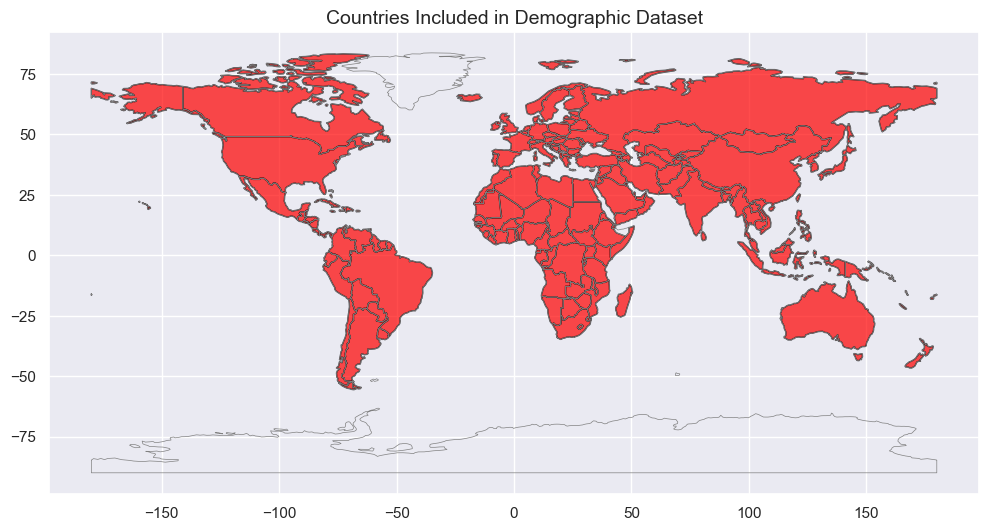

In [196]:
countries_in_data = population['region'].values

# Load world map data
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

world_filtered = world[world["iso_a3"].isin(countries_in_data)]

# Plot world map
fig, ax = plt.subplots(figsize=(12, 6))
world.boundary.plot(ax=ax, color="gray", linewidth=0.5)  # Base map in gray
world_filtered.plot(ax=ax, color="red", edgecolor="black", alpha=0.7)  # Highlight countries in data

plt.title("Countries Included in Demographic Dataset", fontsize=14)

### Save the total population for each age group as pop_by_age.nc

In [202]:
population.to_netcdf(f'./demographic/countries/pop_by_age.nc')

In [53]:
pop_by_age = xr.open_mfdataset(f'./demographic/countries/pop_by_age.nc')

## Open pop_by_age and then divide by the total population for each country (population_new.csv)

In [10]:
demographic = pd.read_csv(f'./demographic/countries/population_new.csv')

In [13]:
demographic = demographic[demographic['Model'] == 'IIASA-WiC POP']

In [55]:
pop_by_age_x = pop_by_age
for i in range(12):
    pop_by_age_x[list(age_theta)[i]] = (pop_by_age[list(age_theta)[i]]/(demographic['2020']*1e6))

In [60]:
pop_by_age_x.to_netcdf(f'./demographic/pop_by_age_frac.nc')